In [1]:
import numpy as np
import scipy.stats
import json
from collections import defaultdict
from scipy import spatial
import matplotlib.pyplot as plt
from collections import Counter
from validate_semantics import load_wordnet_axes, get_glove_vecs
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
ROOT = '/mnt/data0/lucy/manosphere/'
DATA = ROOT + 'data/'
GLOVE = DATA + 'glove/'
LOGS = ROOT + 'logs/'

### Axes in vector space

In [3]:
axes, axes_vocab = load_wordnet_axes()
glove_vecs = get_glove_vecs(set(), axes_vocab, exp_name='default')

In [70]:
def show_top_axes(path, scores, show_bias=True, show_effect=True):
    with open(path, 'r') as infile:
        biases = json.load(infile) # {c : { pole : (bias, effect) } }
        
    for c in biases:
        if not show_bias: continue
        print("**** BIAS ****", c)
        vals = []
        dims = []
        for pole in biases[c]: 
            p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            # separability
            if scores[pole + '_left'][0] >= 0 and scores[pole + '_right'][0] >= 0:
                dims.append((pole, round(b_t_f2, 3)))
                vals.append(abs(b_t_f2))
        sorted_dims = [x for _,x in sorted(zip(vals,dims))]
        for i in range(1, 6): 
            pole, bias = sorted_dims[-i]
            left, right = axes[pole]
            p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            if b_t_f2 > 0: 
                this_side = left
            elif b_t_f2 <= 0: 
                this_side = right
            random.seed(0)
            adj_sample = random.sample(this_side, min(len(this_side), 10))
            print(bias, pole, ', '.join(adj_sample))
        print()

    for c in biases: 
        if not show_effect: continue
        print("**** DIFF ****", c)
        vals = []
        dims = []
        for pole in biases[c]: 
            p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            # separability + statistical significance
            if scores[pole + '_left'][0] >= 0 and scores[pole + '_right'][0] >= 0 and p_val < 0.001:
                dims.append((pole, round(b_t_f2, 3)))
                vals.append(abs(effect))
        sorted_dims = [x for _,x in sorted(zip(vals,dims))]
        num_examples = min(len(sorted_dims)+1, 6)
        for i in range(1, num_examples): 
            pole, bias = sorted_dims[-i]
            left, right = axes[pole]
            p_val, effect, b_t_f1, b_t_f2 = biases[c][pole]
            if b_t_f2 > 0 and effect > 0: 
                this_side = left
                degree = 'more'
            elif b_t_f2 > 0 and effect <= 0: 
                this_side = left
                degree = 'less'
            elif b_t_f2 <= 0 and effect > 0: 
                this_side = right
                degree = 'less'
            elif b_t_f2 <= 0 and effect <= 0: 
                this_side = right
                degree = 'more'
            random.seed(0)
            adj_sample = random.sample(this_side, min(len(this_side), 10))
            print(round(effect, 3), bias, pole, degree.upper(), ', '.join(adj_sample))
        print()

In [30]:
def get_occ_sent_counts(): 
    with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
        occ_sents = json.load(infile)
    with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile: 
        lexicon_dict = json.load(infile)
    occ_cat = defaultdict(list)
    for c in lexicon_dict: 
        for occ in lexicon_dict[c]['high']: 
            occ_cat[occ].append(c)
    occ_cat_counts = defaultdict(Counter)
    for occ in occ_sents: 
        for cat in occ_cat[occ]: 
            occ_cat_counts[cat][occ] = len(occ_sents[occ])
    for cat in occ_cat_counts: 
        print(cat.upper())
        print(len(occ_cat_counts[cat]))
        for tup in occ_cat_counts[cat].most_common(): 
            print('\t', tup[0], tup[1])

In [31]:
get_occ_sent_counts()

GOVERNMENT
47
	 mayor 127
	 ombudsman 98
	 governor 56
	 aide-de-camp 44
	 sheriff 32
	 ambassador 28
	 prosecutor 26
	 fence viewer 22
	 acting governor 22
	 official 19
	 alderman 17
	 permanent secretary 15
	 city manager 10
	 attaché 10
	 sovereign 9
	 city attorney 9
	 deputy mayor 8
	 advocate general 8
	 drain commissioner 8
	 undersecretary 7
	 postmaster 6
	 royal secretary 6
	 gold commissioner 6
	 treasurer 5
	 municipal commissioner 5
	 press secretary 4
	 state architect 4
	 appraiser 4
	 county administrator 4
	 tax collector 3
	 courtier 3
	 cultural attaché 3
	 permanent representative 3
	 intelligence officer 3
	 county surveyor 2
	 council architect 2
	 village accountant 2
	 cabinet secretary 2
	 hardship post 2
	 acting president 2
	 bureaucrat 2
	 language commissioner 1
	 pursuivant 1
	 county executive 1
	 sub-divisional magistrate 1
	 municipal clerk 1
	 postal worker 1
HEALTH
47
	 midwife 44
	 pharmacist 32
	 psychologist 29
	 pharmacy technician 24
	 dental as

### Occupation and self-consistency evaluation

In [32]:
def mean_confidence_interval(data, confidence=0.90):
    '''
    copied from https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def plot_axes_quality(exp_name, do_plot=True): 
    quality_file_path = LOGS + 'semantics_val/axes_quality_' + exp_name + '.txt'
    scores = defaultdict(dict) # {synset: {word : (predicted, true)}}
    with open(quality_file_path, 'r') as infile: 
        for line in infile: 
            contents = line.strip().split('\t')
            scores[contents[0]][contents[1]] = (float(contents[2]), contents[3])
    avg_scores = Counter()
    ci_scores = Counter()
    good_count = 0
    for synset in scores: 
        left_scores = []
        right_scores = []
        for w in scores[synset]: 
            if scores[synset][w][1] == 'left': 
                left_scores.append(-1*scores[synset][w][0])
            else: 
                right_scores.append(scores[synset][w][0])
        if left_scores != []: 
            # some are empty since they only had one word with reps
            avg_scores[synset + '_left'] = np.mean(left_scores) 
            ci_scores[synset + '_left'] = mean_confidence_interval(left_scores)
        if right_scores != []: 
            avg_scores[synset + '_right'] = np.mean(right_scores) 
            ci_scores[synset + '_right'] = mean_confidence_interval(right_scores)
        if avg_scores[synset + '_left'] >= 0 and avg_scores[synset + '_right'] >= 0: 
            good_count += 1
    ordered_scores = avg_scores.most_common()
    avg_sim = np.mean(list(avg_scores.values()))
    if do_plot: 
        print("BEST", ordered_scores[:10])
        print("WORST", ordered_scores[::-1][:10])
        print("AVG SIMILARITY TO CORRECT SIDE:", avg_sim)
        print("STANDARD DEVIATION:", np.std(list(avg_scores.values())))
        print("GOOD AXES COUNT:", good_count)
        plt.hist(avg_scores.values(), density=True, bins=20)
        plt.axvline(x=np.mean(list(avg_scores.values())), color='red')
        plt.ylabel('frequency')
        plt.xlabel('similarity to correct side')
        plt.title(exp_name)
        plt.show()
    return ci_scores, avg_sim, good_count

BEST [('cardinal.a.02_right', 0.46587843275706514), ('democratic.a.01_right', 0.45688202820996093), ('established.a.01_right', 0.4457313786380787), ('proved.a.01_right', 0.4400854343410742), ('diligent.a.02_left', 0.4298208091532249), ('used.a.01_left', 0.42174856144216466), ('prospective.a.01_left', 0.4127038229058156), ('partial.a.02_right', 0.3980450580154516), ('nourished.a.01_right', 0.3915070398937059), ('all.a.01_left', 0.3797426857709725)]
WORST [('leeward.a.01_left', -0.2969628124826152), ('left-handed.a.01_left', -0.27629508544904546), ('east.a.01_right', -0.2724861278640515), ('alkaline.a.01_left', -0.2609350143981471), ('western.a.02_left', -0.2469994684001294), ('right-handed.a.01_right', -0.22041623298552349), ('same.a.01_left', -0.21482705170077418), ('left-handed.a.01_right', -0.1928498721136952), ('right.a.01_right', -0.1880249658281328), ('like.a.01_left', -0.18562359995196703)]
AVG SIMILARITY TO CORRECT SIDE: 0.10148170209867674
STANDARD DEVIATION: 0.1126810881944173

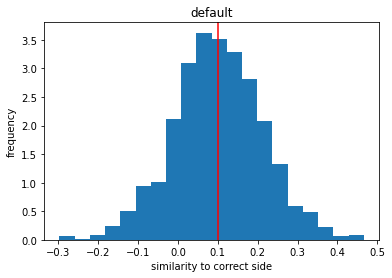

In [33]:
# GloVe 
scores1, _, _ = plot_axes_quality('default')

In [34]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_default.json', scores1, show_effect=False)

**** BIAS **** Writing
0.189 employed.a.01 working, engaged, employed, hired
0.178 original.a.03 innovative, seminal, avant-garde, germinal, new, fresh, freehand, original, groundbreaking, newfangled
0.177 skilled.a.01 practiced, proficient, adept, hot, skilled, expert, virtuoso, consummate, good, delicate
0.176 known.a.01 well-known, illustrious, renowned, best-known, famous, legendary, known, famed, celebrated, proverbial
-0.175 dominant.a.01 under, low-level, subordinate, adjunct, assistant, associate, secondary

**** BIAS **** Theater, film, TV, entertainment
0.196 employed.a.01 working, engaged, employed, hired
0.192 known.a.01 well-known, illustrious, renowned, best-known, famous, legendary, known, famed, celebrated, proverbial
0.191 skilled.a.01 practiced, proficient, adept, hot, skilled, expert, virtuoso, consummate, good, delicate
-0.19 dominant.a.01 under, low-level, subordinate, adjunct, assistant, associate, secondary
0.186 typical.a.01 veritable, representative, typical, e

BEST [('cosmopolitan.a.02_left', 0.4688037444572688), ('established.a.01_right', 0.4596850064984086), ('diligent.a.02_left', 0.44453673857165804), ('perfect.a.01_right', 0.4236236618175155), ('democratic.a.01_right', 0.42250865007703964), ('coastal.a.02_left', 0.4197461159100794), ('rural.a.01_right', 0.404912632665243), ('loyal.a.01_right', 0.40454635135829137), ('proved.a.01_right', 0.4010928313641157), ('accordant.a.01_right', 0.3786686542925012)]
WORST [('right.a.07_right', -0.24983714360112655), ('middle-class.a.01_right', -0.21872887699865978), ('lower-class.a.01_right', -0.2060201658683339), ('left-handed.a.01_left', -0.2055182739316395), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('simple.a.06_right', -0.18363307685494304), ('plausible.a.01_left', -0.18247291968936494), ('upper-class.a.01_left', -0.18238383433328156), ('right-handed.a.01_right', -0.16924812978017423)]
AVG SIMILARITY TO CORRECT SIDE: 0.08362568852321235
ST

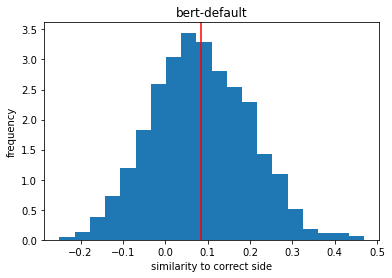

In [35]:
scores2, _, _ = plot_axes_quality('bert-default')

In [36]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-default.json', scores2, show_effect=False)

**** BIAS **** Writing
0.16 creative.a.01 yeasty, imaginative, notional, creative, fanciful, fictive, inventive
0.147 colorful.a.02 jazzy, sporty, brave, gaudy, many-sided, flashy, colourful, showy, gay, noisy
0.147 intellectual.a.02 sophisticated, rational, serious, good, highbrow, intellectual, reflective
0.138 high.a.04 shrill, sopranino, altissimo, peaky, squeaking, spiky, high-pitched, treble, falsetto, nasal
0.132 controlled.a.01 possessed, regimented, dominated, contained, disciplined, obsessed, controlled, harnessed

**** BIAS **** Theater, film, TV, entertainment
0.145 ready.a.01 waiting, ready, set, fit, primed, prompt, ripe
0.144 organized.a.01 reorganised, reorganized, incorporated, arranged, corporate, re-formed, configured, organized
0.141 colorful.a.02 jazzy, sporty, brave, gaudy, many-sided, flashy, colourful, showy, gay, noisy
0.138 intellectual.a.02 sophisticated, rational, serious, good, highbrow, intellectual, reflective
0.137 rhetorical.a.02 tall, oratorical, styli

In [37]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-default.json', scores2, show_bias=False)

**** DIFF **** Writing
-0.018 -0.096 pious.a.01 MORE impious, irreverent, godless
-0.017 -0.112 armed.a.01 MORE defenseless, weaponless, barehanded, clean, defenceless, unarmed
-0.017 -0.042 consecrated.a.01 MORE violated, desecrated, deconsecrated, profaned
-0.017 -0.185 military.a.03 MORE civilian, noncombatant, civil
-0.017 -0.046 holy.a.01 MORE unconsecrated, unholy, profane

**** DIFF **** Theater, film, TV, entertainment
0.025 0.091 employed.a.01 MORE working, engaged, employed, hired
0.022 0.198 susceptible.a.01 MORE subject, suggestible, amenable, pliable, susceptible, persuadable, open, liable, unvaccinated, nonresistant
0.019 0.089 assisted.a.01 MORE assisted, power-assisted, aided
0.018 0.056 private.a.01 MORE one-on-one, private, clannish, head-to-head, secluded, reclusive, snobby, privy, secret, close
-0.018 -0.001 dominant.a.01 MORE under, low-level, subordinate, adjunct, assistant, associate, secondary

**** DIFF **** Artistic
0.026 0.099 smart.a.01 MORE smart, streetwis

BEST [('established.a.01_right', 0.7294871953224412), ('proved.a.01_right', 0.6003769027690024), ('coastal.a.02_left', 0.534377121387999), ('diligent.a.02_left', 0.516783715891913), ('metallic.a.01_right', 0.49643004925960144), ('democratic.a.01_right', 0.48636240376103274), ('shod.a.01_right', 0.4850944448444688), ('plowed.a.01_left', 0.4707722675369253), ('rural.a.01_right', 0.46622151722676325), ('simple.a.06_left', 0.46490348156035904)]
WORST [('right.a.07_right', -0.3167768528796098), ('simple.a.06_right', -0.2753792586020164), ('bidirectional.a.01_right', -0.26510131944057097), ('lower-class.a.01_right', -0.23113754876505607), ('digestible.a.01_left', -0.2310606702300178), ('right-handed.a.01_right', -0.22672592475482176), ('carnivorous.a.02_left', -0.22394346918759292), ('alkaline.a.01_left', -0.21794843798810126), ('right.a.01_right', -0.2162411538762183), ('middle-class.a.01_right', -0.20458877321276514)]
AVG SIMILARITY TO CORRECT SIDE: 0.11119279037123038
STANDARD DEVIATION: 

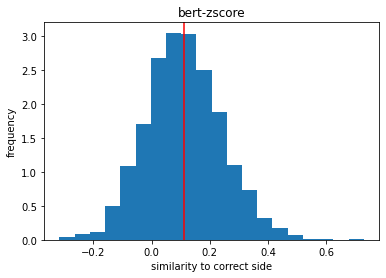

In [38]:
scores3, _, _ = plot_axes_quality('bert-zscore')

In [39]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-zscore.json', scores3, show_effect=False)

**** BIAS **** Writing
0.155 humane.a.02 humanist, humanitarian, child-centered, human-centered, humane, humanistic
0.147 creative.a.01 yeasty, imaginative, notional, creative, fanciful, fictive, inventive
0.135 punctual.a.01 punctual, timely, prompt
0.124 constructive.a.01 rehabilitative, structural, constructive, formative, plastic, inferential, creative, reconstructive, shaping
0.123 reasonable.a.01 reasonable, well-founded, commonsense, level-headed, sensible, intelligent, levelheaded, healthy, commonsensical, tenable

**** BIAS **** Theater, film, TV, entertainment
0.14 constructive.a.01 rehabilitative, structural, constructive, formative, plastic, inferential, creative, reconstructive, shaping
0.128 serviceable.a.01 useable, operational, usable, durable, functional, operable, serviceable
0.127 manageable.a.01 governable, steerable, controllable, directed, dirigible, manageable
0.125 operative.a.01 working, operating, operative, effective, good, operant, operational
-0.123 tough.a

In [40]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-zscore.json', scores3, show_bias=False)

**** DIFF **** Writing
-0.026 -0.086 used.a.01 MORE victimized, put-upon, victimised, abused, exploited, misused, used
0.025 0.055 corrupt.a.01 MORE sold-out, vitiated, dishonest, corrupt, depraved, perverted, perverse, sordid, reprobate, debased
-0.023 -0.014 dignified.a.01 MORE silly, undignified, mortifying, demeaning, humiliating, ridiculous, humbling, pathetic
-0.023 -0.005 authorized.a.01 MORE unauthorized, unlicensed, self-appointed, unaccredited, unauthorised, unlicenced
0.022 0.168 single.a.03 MORE single, unique, lone, one-woman, singular, one-person, one-man, unary, only, sole

**** DIFF **** Theater, film, TV, entertainment
0.032 0.034 employed.a.01 MORE working, engaged, employed, hired
0.024 0.029 assisted.a.01 MORE assisted, power-assisted, aided
-0.023 0.055 corrigible.a.01 LESS correctable, redeemable, amendable
0.023 0.032 persuasive.a.01 MORE weighty, glib, telling, coaxing, cogent, compelling, persuasive
0.022 0.025 emotional.a.02 MORE soupy, low-down, slushy, lyric

BEST [('rural.a.01_right', 0.529845619677176), ('supported.a.01_left', 0.4991604550534514), ('neutral.a.04_left', 0.4922054482904713), ('established.a.01_right', 0.4596850064984086), ('diligent.a.02_left', 0.44453673857165804), ('homemade.a.01_right', 0.4440195672746544), ('free.a.02_right', 0.4379359447352209), ('coastal.a.02_left', 0.4280512965763742), ('democratic.a.01_right', 0.4246738305776526), ('cooked.a.01_left', 0.4237845475586477)]
WORST [('leeward.a.01_left', -0.4175647702020044), ('left-handed.a.01_right', -0.23861454056213316), ('fast.a.03_left', -0.22477515541403129), ('lower-class.a.01_right', -0.2060201658683339), ('binaural.a.01_left', -0.20288012219365292), ('carnivorous.a.02_left', -0.20271160378624717), ('bidirectional.a.01_right', -0.2004641383563981), ('loving.a.01_right', -0.19716712279876103), ('perpendicular.a.01_right', -0.19567708897485708), ('middle-class.a.01_right', -0.19348844866023118)]
AVG SIMILARITY TO CORRECT SIDE: 0.10083061729642588
STANDARD DEVIATI

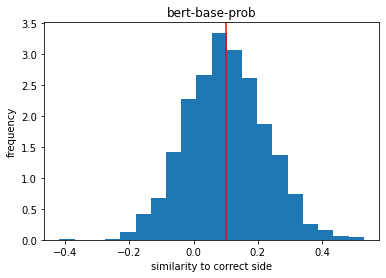

In [41]:
scores7, _, _ = plot_axes_quality('bert-base-prob')

In [42]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob.json', scores7, show_effect=False)

**** BIAS **** Writing
0.192 creative.a.01 yeasty, imaginative, notional, creative, fanciful, fictive, inventive
0.158 preceding.a.01 precedent, previous, above, introductory, prefatory, preceding, foregoing, above-named, preparatory, old
-0.153 fatty.a.01 nonfat, skimmed, fat-free, light, lite, skim
0.151 intended.a.01 measured, witting, calculated, deliberate, intentional, intended, knowing, conscious, well-meaning, well-intentioned
0.147 intellectual.a.02 sophisticated, rational, serious, good, highbrow, intellectual, reflective

**** BIAS **** Theater, film, TV, entertainment
0.166 creative.a.01 yeasty, imaginative, notional, creative, fanciful, fictive, inventive
-0.153 live.a.01 transcribed, recorded, taped, canned, filmed, prerecorded, tape-recorded
-0.148 rounded.a.01 rectangular, tricuspid, angled, cusped, square-shaped, bicuspid, asteroid, triangular, equiangular, star-shaped
0.147 controlled.a.01 possessed, regimented, dominated, contained, disciplined, obsessed, controlled,

In [43]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob.json', scores7, show_bias=False)

**** DIFF **** Writing
-0.024 -0.079 noble.a.02 MORE untitled, vulgar, base, humble, lowly, ignoble, common, plebeian, unwashed
-0.022 -0.003 authorized.a.01 MORE unauthorized, unlicensed, self-appointed, unaccredited, unauthorised, unlicenced
-0.019 0.036 prepared.a.01 LESS processed, up, braced, equipped, precooked, preconditioned, prepared, embattled, spread, ready
-0.018 -0.096 pious.a.01 MORE impious, irreverent, godless
0.018 0.175 active.a.03 MORE proactive, activist, active, hands-on

**** DIFF **** Theater, film, TV, entertainment
-0.023 -0.042 nonproprietary.a.01 MORE proprietary, trademarked, branded, copyrighted, patented
-0.022 -0.001 dominant.a.01 MORE under, low-level, subordinate, adjunct, assistant, associate, secondary
0.021 0.159 susceptible.a.01 MORE subject, suggestible, amenable, pliable, susceptible, persuadable, open, liable, unvaccinated, nonresistant
0.02 0.058 employed.a.01 MORE working, engaged, employed, hired
0.019 0.113 emotional.a.02 MORE soupy, low-down

BEST [('established.a.01_right', 0.7294871953224412), ('supported.a.01_left', 0.7070427658746465), ('rural.a.01_right', 0.6368362719554093), ('free.a.02_right', 0.6017319528162026), ('proved.a.01_right', 0.6003769027690024), ('neutral.a.04_left', 0.5948094838960902), ('coastal.a.02_left', 0.5194626862884067), ('competent.a.01_right', 0.5175961707004377), ('enclosed.a.01_right', 0.5172268188886575), ('diligent.a.02_left', 0.516783715891913)]
WORST [('leeward.a.01_left', -0.4543863593192659), ('analytic.a.03_left', -0.29218387728043854), ('fast.a.03_left', -0.277996883139318), ('bidirectional.a.01_right', -0.26510131944057097), ('left-handed.a.01_right', -0.2590580772150991), ('binaural.a.01_left', -0.2458924394155072), ('right.a.01_right', -0.2372852533326317), ('lower-class.a.01_right', -0.23113754876505607), ('carnivorous.a.02_left', -0.22394346918759292), ('right-handed.a.01_right', -0.2011003457009229)]
AVG SIMILARITY TO CORRECT SIDE: 0.13268899550330066
STANDARD DEVIATION: 0.139890

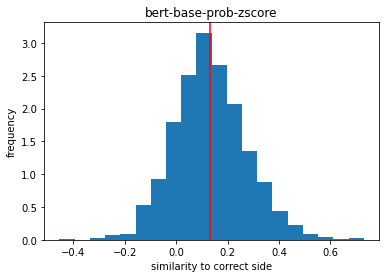

In [44]:
scores8, _, _ = plot_axes_quality('bert-base-prob-zscore')

In [45]:
show_top_axes(LOGS + 'semantics_val/occupations/frameaxis_bert-base-prob-zscore.json', scores8, show_effect=False)

**** BIAS **** Writing
0.159 creative.a.01 yeasty, imaginative, notional, creative, fanciful, fictive, inventive
0.155 logical.a.01 formal, logical, discursive
0.146 humane.a.02 humanist, humanitarian, child-centered, human-centered, humane, humanistic
0.13 constructive.a.01 rehabilitative, structural, constructive, formative, plastic, inferential, creative, reconstructive, shaping
-0.125 separate.a.01 conjunctive, joint, clannish, concerted, conjoint, conjoined, conjunct, collective, corporate, cooperative

**** BIAS **** Theater, film, TV, entertainment
-0.147 live.a.01 transcribed, recorded, taped, canned, filmed, prerecorded, tape-recorded
0.141 constructive.a.01 rehabilitative, structural, constructive, formative, plastic, inferential, creative, reconstructive, shaping
0.137 enthusiastic.a.01 evangelistic, zealous, ardent, enthusiastic, glowing, gaga, dotty, crazy, wild, evangelical
-0.133 separate.a.01 conjunctive, joint, clannish, concerted, conjoint, conjoined, conjunct, collec

In [72]:
show_top_axes(LOGS + 'semantics_val/person/frameaxis_bert-base-prob-zscore.json', scores8, show_bias=False)

**** DIFF **** Writing
[8.570287112536988e-16, -0.0014000993352359936, 0.05120961278856111, 0.049500175021648746]
-0.042 -0.185 formal.a.01 MORE folksy, unceremonious, casual, daily, everyday, informal
-0.031 -0.042 noble.a.02 MORE untitled, vulgar, base, humble, lowly, ignoble, common, plebeian, unwashed
-0.03 0.014 authorized.a.01 LESS commissioned, sanctioned, accredited, canonised, empowered, authorized, authorised, licensed, canonized, glorified
-0.027 -0.085 used.a.01 MORE victimized, put-upon, victimised, abused, exploited, misused, used
-0.026 0.03 prepared.a.01 LESS processed, up, braced, equipped, precooked, preconditioned, prepared, embattled, spread, ready

**** DIFF **** Theater, film, TV, entertainment
[0.0, -0.01033964478838266, 0.05295063283932842, 0.040533381721580254]
-0.027 -0.064 nonproprietary.a.01 MORE proprietary, trademarked, branded, copyrighted, patented
0.026 0.038 emotional.a.02 MORE soupy, low-down, slushy, lyric, bathetic, hokey, mawkish, maudlin, supercha

In [47]:
# U-tests
# z-scored bert prob vs. glove
print(mannwhitneyu(list(scores8.values()), list(scores1.values())))
# z-scored bert prob vs. z-scored bert random
print(mannwhitneyu(list(scores8.values()), list(scores3.values())))
# z-scored bert random vs. glove
print(mannwhitneyu(list(scores3.values()), list(scores1.values())))

MannwhitneyuResult(statistic=array([1176554., 1122316., 1218947.]), pvalue=array([5.25259934e-09, 6.18847666e-04, 1.09989287e-14]))
MannwhitneyuResult(statistic=array([1139122.5, 1097585.5, 1169000. ]), pvalue=array([3.02236649e-05, 2.02477251e-02, 3.74417795e-08]))
MannwhitneyuResult(statistic=array([1077750., 1068427., 1090473.]), pvalue=array([0.1503613 , 0.30630215, 0.04496987]))


# Human evaluation task materials

This section includes metadata used to design the evaluation task, including: 
- example occupations in each category 
- example sentences for each occupation category (taking the first sentence on their page)

In [48]:
with open(DATA + 'semantics/cleaned/occupations.json', 'r') as infile:
    classes = json.load(infile)
with open(DATA + 'semantics/occupation_sents.json', 'r') as infile: 
    occ_sents = json.load(infile)
with open(DATA + 'semantics/person_occupation_sents.json', 'r') as infile: 
    person_occ_sents = json.load(infile)

In [49]:
random.seed(0)
for c in classes: 
    print(c.upper())
    occ_list = [i for i in classes[c]['high'] if i in occ_sents]
    if len(occ_list) > 10: 
        print(', '.join(random.sample(occ_list, 10)))
    else: 
        print(', '.join(occ_list))
    print()

WRITING
dog writer, journalist, staff writer, commissioning editor, griot, screenwriter, freelancer, script doctor, poet, technical writer

THEATER, FILM, TV, ENTERTAINMENT
composer, wardrobe supervisor, film director, costume designer, sound designer, music director, dramaturge, playwright, fly crew, technical director

ARTISTIC
photographer, artisan, lyricist, web designer, interior designer, sculptor, tattoo artist, colorist, singer, architect

HEALTH
ophthalmologist, psychologist, anesthesiologist assistant, dental assistant, dental technician, athletic trainer, neurologist, geriatrician, physician assistant, pharmacist

AGRICULTURE
water boy, agriculturist, husbandman, professional hunter, cattleman, swineherd, yeoman, shepherd, sea shepherd, breeder

GOVERNMENT
city manager, municipal clerk, pursuivant, prosecutor, ambassador, appraiser, postal worker, official, state architect, mayor

SPORTS
football player, triathlete, rower, dancer, figure skater, disc golf, cricketer, judoka,

For the examples below, we choose ones that are not confusing and lightly edit them for clarity, e.g. "A person is a person who" becomes "This person is someone who" before showing them to crowdworkers. 

In [57]:
random.seed(10)
for c in classes: 
    print(c.upper())
    class_sents = []
    for i in classes[c]['high']: 
        if i in person_occ_sents: 
            for sent in person_occ_sents[i]: 
                if c != 'Math & statistics': # need more examples
                    if len(sent.split()) >= 10: 
                        class_sents.append(sent)
                        break
                else: 
                    class_sents.append(sent)
    for sent in class_sents: 
        print(sent)
    print()

WRITING
A person is hired to write literary or journalistic works, speeches, or other texts that are officially credited to another person as the author.
It is the job of the person to advise the publishing house on which books to publish.
A person is an author or writer of novels, though often novelists also write in other genres of both fiction and non-fiction.
A person is a person who is hired to prepare and write speeches that will be delivered by another person.
A person (or scribe) was a person who could read and write or who wrote letters to court and legal documents.
A person is an evaluation of a publication, product, service, or company or a critical take on current affairs in literature, politics or culture.
An person is the creator or originator of any written work such as a book or play, and is also considered a writer or poet.
Shortly thereafter, Evan Williams at Pyra Labs used "blog" as both a noun and verb ("to blog", meaning "to edit one's weblog or to post to one's we

In [51]:
for c in classes: 
    print([i for i in classes[c]['high'] if i in occ_sents and i.endswith('s')])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [52]:
total = 0
for occ in occ_sents: 
    total += len(occ_sents[occ])
print(total)
print(len(occ_sents))

2905
293
